<a href="https://colab.research.google.com/github/elhamsh93/GAN/blob/main/%20WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import os

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader
from torchvision import datasets

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

# Inits

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

channels = 1
img_size = 28
image_shape = torch.tensor([channels, img_size, img_size])

latent_dim = 100
batch_size = 64

lr = 0.0002
b1 = 0.9
b2 = 0.999

n_epochs = 200
lambda_gp = 10.
sample_interval = 200

n_critic = 5

In [30]:
os.makedirs('images', exist_ok=True)
os.makedirs('mnist', exist_ok=True)

# Dataset

In [31]:
transform = transforms.Compose([#transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

dataset = datasets.MNIST('mnist',
                         train=True,
                         download=True,
                         transform=transform)

In [32]:
transforms.ToPILImage()(dataset[0][0])

In [33]:
dataloader = DataLoader(dataset, 
                        batch_size=batch_size,
                        shuffle=True)

In [34]:
batch = next(iter(dataloader))
batch[0].dtype
batch[0].shape

torch.Size([64, 1, 28, 28])

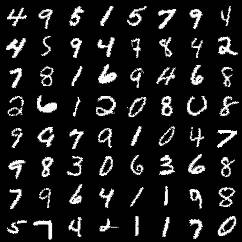

In [35]:
transforms.ToPILImage()(make_grid(batch[0]))

In [36]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    def block(in_feat, out_feat, normalize=True):
      layers = [nn.Linear(in_features=in_feat, out_features=out_feat)]
      if normalize:
        layers.append(nn.BatchNorm1d(out_feat, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers
      
    self.model = nn.Sequential(*block(latent_dim, 128, normalize=False),
                                  *block(128, 256),
                                  *block(256, 512),
                                  *block(512, 1024),
                                  nn.Linear(1024, torch.prod(image_shape)),
                                  nn.Tanh())
    
  def forward(self, z):
    img = self.model(z)
    img = img.view(img.shape[0], *image_shape)
    return img


In [37]:
g = Generator()

In [38]:
g(torch.rand(batch_size, latent_dim)).shape

torch.Size([64, 1, 28, 28])

In [39]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.model = nn.Sequential(nn.Linear(torch.prod(image_shape), 512),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(512, 256),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(256, 1))
    
  def forward(self, img):
    img_flat = img.view(img.shape[0], -1)
    out = self.model(img_flat)
    return out

In [40]:
d = Discriminator()

In [41]:
d(torch.rand(batch_size, *image_shape)).shape

torch.Size([64, 1])

# Autograd

In [42]:
x = torch.tensor(1., requires_grad=True)
y = x + x**3
autograd.grad(outputs=y, inputs=x)[0]

tensor(4.)

In [43]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = x + x**3
autograd.grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(y))[0]

tensor([ 4., 13., 28.])

In [44]:
x = torch.tensor([1., 2., -1, 0], requires_grad=True)
w = torch.tensor(0.5, requires_grad=True)

y = w*x + x**3
autograd.grad(outputs=y, inputs=w, grad_outputs=torch.ones_like(y))[0]

tensor(2.)

In [45]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from torchviz import make_dot

In [47]:
model = nn.Sequential()
model.add_module('w0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('w1', nn.Linear(16, 1))
model

Sequential(
  (w0): Linear(in_features=8, out_features=16, bias=True)
  (tanh): Tanh()
  (w1): Linear(in_features=16, out_features=1, bias=True)
)

In [48]:
x = torch.rand(1, 8)
y = model(x)

In [49]:
dict(model.named_parameters())

{'w0.weight': Parameter containing:
 tensor([[ 0.1896, -0.0665, -0.2651,  0.3378, -0.3013, -0.2106, -0.2524, -0.1582],
         [ 0.0485,  0.0159, -0.1458, -0.2606,  0.0094,  0.1290,  0.2651,  0.3450],
         [ 0.3473, -0.0296,  0.1832,  0.1474,  0.0767,  0.1417,  0.0851, -0.1752],
         [ 0.0312,  0.3234, -0.3384,  0.0393,  0.1309, -0.2055, -0.1813, -0.0988],
         [ 0.2929,  0.2858,  0.0807,  0.0054,  0.3440,  0.2838,  0.3182, -0.1664],
         [-0.3293, -0.2331,  0.3145, -0.0730, -0.2299, -0.0021,  0.3110, -0.2948],
         [ 0.2637, -0.1048, -0.2852,  0.3501, -0.1961,  0.0557, -0.0872, -0.2535],
         [ 0.1661,  0.3329, -0.2001,  0.3440,  0.0611,  0.2665,  0.1528, -0.1925],
         [ 0.0703, -0.3034,  0.0181,  0.3055,  0.1431, -0.2615, -0.0238,  0.2257],
         [-0.1960,  0.2273, -0.3531,  0.1584,  0.1884, -0.3477, -0.2821, -0.1668],
         [ 0.0390, -0.2894, -0.0720,  0.3410, -0.2067,  0.1993, -0.2183, -0.3365],
         [-0.3112, -0.2207, -0.2055, -0.0659, -0.17

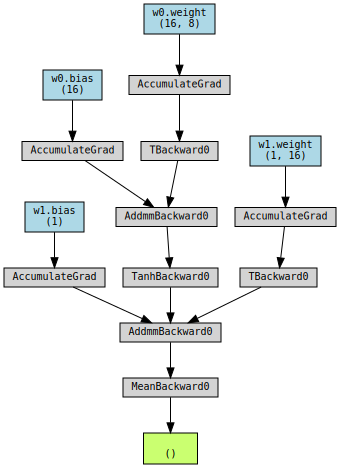

In [50]:
make_dot(y.mean(), params = dict(model.named_parameters()))

In [51]:
b2 = torch.randn(1)
w2 = torch.randn(1, requires_grad=True)
x2 = torch.tensor([1., 2., 3.], requires_grad=True)
y2 = torch.tensor([1., 2., 3.])

yp2 = b2 + w2*x2
error2 = (y2 - yp2)**2
loss2 = error2.mean()

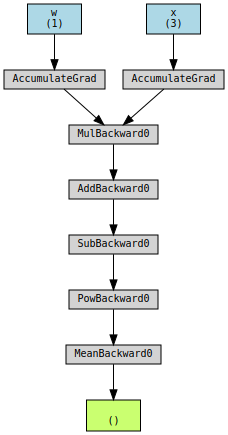

In [52]:
make_dot(loss2, params = {'w':w2, 'x':x2})

# Config

In [53]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [54]:
optimizer_G = torch.optim.Adam(generator.parameters(),
                               lr=lr,
                              # betas=(b1, b2)
                              )

optimizer_D = torch.optim.Adam(discriminator.parameters(),
                               lr=lr,
                              #  betas=(b1, b2)
                               )

In [55]:
torch.normal(0, 1, size=(64, latent_dim))

tensor([[ 2.1629,  1.3119,  0.8149,  ...,  1.0717,  0.4091,  0.5197],
        [ 1.6056, -1.6861,  0.9483,  ...,  1.7464, -0.6309, -0.9484],
        [-0.2764, -1.9347, -0.5662,  ..., -0.8947, -0.0312, -0.5047],
        ...,
        [-0.4521, -0.6026, -0.3321,  ...,  0.1733, -0.6315,  0.6259],
        [ 0.5482,  0.9842,  1.3423,  ...,  0.4418, -0.2495, -0.2517],
        [-1.2250,  0.7233,  1.1658,  ..., -0.5800,  0.1082,  0.6928]])

In [56]:
# alpha = torch.rand((64, 1, 1, 1), device=device)
# x_hat = alpha * real_imgs + (1 - alpha) * fake_imgs
# y_hat= discriminator(x_hat)

In [57]:
# gradients = autograd.grad(outputs=y_hat,
#                           inputs= x_hat,
#                           grad_outputs=torch.ones_like(y_hat))[0]
# gradients

In [58]:
def compute_gradient_penalty(D, real_samples, fake_samples):
  alpha = torch.rand((real_samples.shape[0], 1, 1, 1), device=device)
  x_hat = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
  y_hat= D(x_hat)
  gradients = autograd.grad(outputs=y_hat,
                          inputs= x_hat,
                          grad_outputs=torch.ones_like(y_hat),
                          create_graph=True)[0]
  gradients = gradients.view(gradients.shape[0], -1)
  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
  return gradient_penalty

In [ ]:
batches_done = 0

for epoch in range(n_epochs):
  for i, (imgs, _) in enumerate(dataloader):
    # Real
    real_imgs = imgs.to(device)
    # Noise
    z = torch.normal(0, 1, size=(imgs.shape[0], latent_dim)).to(device)

    # Train Discriminator
    optimizer_D.zero_grad()

    fake_imgs = generator(z)

    real_out = discriminator(real_imgs)
    fake_out = discriminator(fake_imgs)

    gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs)

    d_loss = -torch.mean(real_out) + torch.mean(fake_out) + lambda_gp * gradient_penalty
    d_loss.backward()

    optimizer_D.step()
    optimizer_G.zero_grad()

    # Train Generator
    if i % n_critic == 0:

      fake_imgs = generator(z)
      fake_out = discriminator(fake_imgs)

      g_loss = -torch.mean(fake_out)
      g_loss.backward()
      optimizer_G.step()

      print(f'[Epoch:{epoch}], [D Loss:{d_loss}], [G Loss:{g_loss}]')

      if batches_done % sample_interval == 0:
        save_image(fake_imgs, f'images{batches_done}.png', normalize=True)
      
      batches_done += n_critic

      


[Epoch:0], [D Loss:8.168342590332031], [G Loss:0.02635708823800087]
[Epoch:0], [D Loss:5.449713230133057], [G Loss:0.018697481602430344]
[Epoch:0], [D Loss:0.4031844139099121], [G Loss:-0.010289779864251614]
[Epoch:0], [D Loss:-7.028310298919678], [G Loss:-0.07755673676729202]
[Epoch:0], [D Loss:-16.43770980834961], [G Loss:-0.1977086067199707]
[Epoch:0], [D Loss:-25.02004051208496], [G Loss:-0.40895217657089233]
[Epoch:0], [D Loss:-30.098508834838867], [G Loss:-0.6837940216064453]
[Epoch:0], [D Loss:-30.62473487854004], [G Loss:-0.9614627361297607]
[Epoch:0], [D Loss:-32.20907211303711], [G Loss:-1.111946702003479]
[Epoch:0], [D Loss:-33.90589141845703], [G Loss:-1.1787388324737549]
[Epoch:0], [D Loss:-34.52134704589844], [G Loss:-1.2262933254241943]
[Epoch:0], [D Loss:-33.409423828125], [G Loss:-1.3336279392242432]
[Epoch:0], [D Loss:-33.65448760986328], [G Loss:-1.4949533939361572]
[Epoch:0], [D Loss:-33.60804748535156], [G Loss:-1.7663377523422241]
[Epoch:0], [D Loss:-33.2661361694